(ch_matmul_cpu)=
# CPU 矩阵乘法

NumPy 的 `dot` 算子在 {ref}`ch_cpu_arch` 中几乎达到了 CPU (Xeon E5-2686 v4) 的性能峰值。在本节中，将研究 TVM 中该算子的多种调度策略。

## 配置


In [1]:
%matplotlib inline
from tvm_book.contrib import d2ltvm
import numpy as np
import timeit
import tvm
from tvm import te

target = "llvm" #'llvm -mcpu=skylake-avx512'

正如在 {ref}`ch_vector_add_cpu` 中所做的那样，首先定义了方法来测量 NumPy 的性能作为基准。

In [2]:
# Save to the d2ltvm package.
def np_matmul_timer(n):
    timer = timeit.Timer(setup='import numpy as np\n'
                         'from tvm_book.contrib import d2ltvm\n'
                         'a, b, c = d2ltvm.get_abc(%s)' % str((n,n)),
                         stmt = 'np.dot(a, b, out=c)')
    return timer.timeit

sizes = 2**np.arange(5, 12, 1)
exe_times = [d2ltvm.bench_workload(np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(exe_times)

## 默认调度

默认调度由三个嵌套的 for 循环组成。

In [3]:
def default(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    return te.create_schedule(C.op), (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) {
    for (y: int32, 0, 64) {
      C[((x*64) + y)] = 0f32
      for (k: int32, 0, 64) {
        let cse_var_2: int32 = (x*64)
        let cse_var_1: int32 = (cse_var_2 + y)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + y)]))
      }
    }
  }
}




为了评测它的性能，还定义了可重用的方法，就像在 {ref}`ch_vector_add_cpu` 中做的那样。

In [4]:
# Save to the d2ltvm package.
def bench_matmul_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.device(target, 0)
        a, b, c = d2ltvm.get_abc((n, n), lambda x: tvm.nd.array(x, ctx))
        times.append(d2ltvm.bench_workload(workload))
    return 2 * sizes**3 / 1e9 / np.array(times)

默认调度遵循如下所示的计算 {ref}`fig_matmul_default`。默认的调度不能很好地执行，这并不奇怪，特别是对于无法放入缓存的大型矩阵。

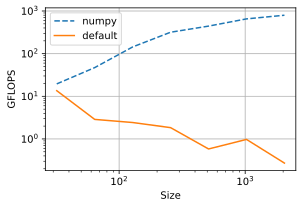

In [5]:
default_gflops = bench_matmul_tvm(default, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

## 重新排序轴

{ref}`fig_matmul_default` 的第一个问题是矩阵 $B$ 是按列访问的，而它的元素是按行存储的（即矩阵 $B$ 属于 [row-major](https://en.wikipedia.org/wiki/Row-_and_column-major_order) ）。换句话说，在上面的伪代码中，在轴 `k` 之前迭代轴 `y`。只要简单地切换这两个 for 循环，就可以按顺序读取和写入所有元素。{ref}`fig_matmul_reorder` 说明了数据访问模式的改变。

(fig_matmul_reorder)=
```{figure} ../img/matmul_reorder.svg
在矩阵乘法中重新排列坐标轴
```

为了实现它，通过 `reorder` 原语将轴的顺序从 (`x`, `y`, `k`) 更改为 (`x`, `k`, `y`)。

相应的伪代码验证我们现在正在逐行处理所有矩阵。

In [6]:
def reorder(n):
    s, (A, B, C) = default(n)
    (x, y), (k,) = C.op.axis, C.op.reduce_axis
    s[C].reorder(x, k, y)
    return s, (A, B, C)

s, args = reorder(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) {
    for (y.init: int32, 0, 64) {
      C[((x*64) + y.init)] = 0f32
    }
    for (k: int32, 0, 64) {
      for (y: int32, 0, 64) {
        let cse_var_2: int32 = (x*64)
        let cse_var_1: int32 = (cse_var_2 + y)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + y)]))
      }
    }
  }
}




可以看到，与默认调度相比，重新排序显著提高了性能。

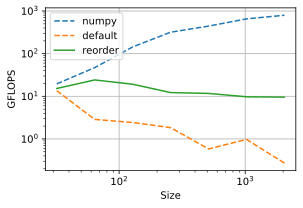

In [7]:
reorder_gflops = bench_matmul_tvm(reorder, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops],
            ['numpy', 'default', 'reorder'])

## 并行化

重新查看上面的伪代码。在最外层的 for 循环 `for (x, 0, 64)` 中，每次计算 $C$ 中一行的结果。每一行都可以并行计算，所以可以让调度并行化 `x` 轴。

In [8]:
def parallel(n):
    s, (A, B, C) = reorder(n)
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) "parallel" {
    for (y.init: int32, 0, 64) {
      C[((x*64) + y.init)] = 0f32
    }
    for (k: int32, 0, 64) {
      for (y: int32, 0, 64) {
        let cse_var_2: int32 = (x*64)
        let cse_var_1: int32 = (cse_var_2 + y)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + y)]))
      }
    }
  }
}




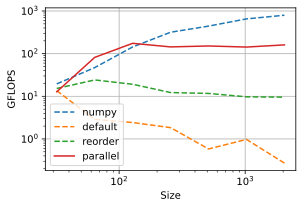

In [9]:
parallel_gflops = bench_matmul_tvm(parallel, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops, parallel_gflops],
            ['numpy', 'default', 'reorder', 'parallel'])

并行化再次提高了性能。但可以看到，与 NumPy 相比，在大型矩阵上仍然存在差距，特别是当它们无法放入 L2 缓存时。将在下一节中解决它。

## 小结

- 对矩阵乘法中的 for 循环进行适当的排序可以提高性能。
- 适当的线程级并行也可以提高性能。

## 练习

1. 更改线程数
1. 尝试用不同的 `parallel` 方法排列坐标轴
1. 更大尺寸的基准矩阵乘法